In [166]:
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import random
import time

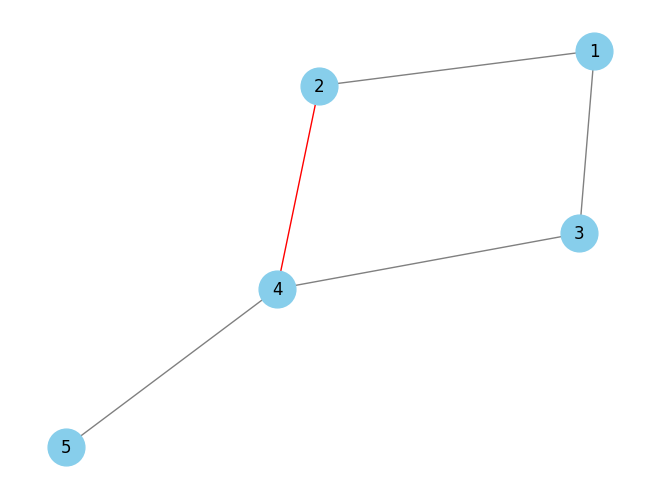

In [167]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()
G.add_edges_from([(1, 2), (1, 3), (2, 4), (3, 4), (4, 5)])

# Choose special edges
special_edges = [(2, 4)]

# Build color list
edge_colors = ['red' if edge in special_edges or (edge[1], edge[0]) in special_edges else 'gray' for edge in G.edges()]

# Draw graph
pos = nx.spring_layout(G)  # layout for consistent positions
nx.draw(G, pos, with_labels=True, edge_color=edge_colors, node_color='skyblue', node_size=700)
plt.show()


In [168]:
class graph:
    def __init__(self, n):
        self.n = n
        self.edges = []
        self.adj = [[] for _ in range(n+1)]  # nodes 1..n

    def add_edge(self, u, v, w=0):
        self.adj[u].append((v, w))
        self.edges.append((u, v, w))
    
    def bfs(self, s):
        l = [s]
        r = [s]
        vis = [0]*(self.n+1)
        vis[s] = 1
        while l:
            x = l.pop(0)
            for v, _ in self.adj[x]:
                if not vis[v]:
                    vis[v] = 1
                    l.append(v)
                    r.append(v)
        return r

In [169]:
class DP_Hamiltionpath:
    def __init__(self, g, source, sink):
        self.g = g
        self.n = g.n 
        self.dp = [[-1]*(1 << (self.n+1)) for _ in range(self.n+1)]
        self.source = source
        self.sink = sink
    
    def DP_compute(self, i, mask):
        if mask == (1 << i) and i == self.sink:  # only sink node left
            return 1
        if i == self.sink:  # reached sink but other nodes remain
            return 0
        if self.dp[i][mask] != -1:
            return self.dp[i][mask]
        
        res = 0
        for v, _ in self.g.adj[i]:
            if mask & (1 << v):
                res = max(res, self.DP_compute(v, mask ^ (1 << i)))
        self.dp[i][mask] = res
        return res
    
    def _get(self):
        mask = (1 << (self.n+1))-1 
        mask^=(1<<self.source)
        return self.DP_compute(self.source, mask)
    def _get_path(self):
        mask = (1 << (self.n + 1)) - 2  # Initial mask with bits 1..n set
        if self.DP_compute(self.source, mask) == 0:
            return []  # No Hamiltonian path exists
        
        path = []
        current_node = self.source
        current_mask = mask
        
        while current_node != self.sink:
            path.append(current_node)
            found = False
            for v, _ in self.g.adj[current_node]:
                if (current_mask & (1 << v)) and self.dp[v][current_mask ^ (1 << current_node)] == 1:
                    current_mask ^= (1 << current_node)
                    current_node = v
                    found = True
                    break
            if not found:
                break  # Shouldn't happen if Hamiltonian path exists
        
        path.append(self.sink)
        return path
    


In [170]:
g=graph(5)
g.add_edge(1,2)
g.add_edge(2,1)
g.add_edge(2,3)
g.add_edge(3,2)
g.add_edge(3,4)
g.add_edge(4,3)
g.add_edge(4,5)
g.add_edge(5,4)
g.add_edge(2,5)
g.add_edge(2,4)
g.add_edge(5,3)
g.add_edge(5,1)
dp_solver=DP_Hamiltionpath(g,2,1)
print(dp_solver._get())
print(dp_solver._get_path())


0
[2, 3, 4, 5, 1]


In [171]:
G_nx = nx.Graph()

# Add all nodes
for u in range(1, g.n + 1):
    G_nx.add_node(u)

# Add all edges
for u, v, w in g.edges:
    G_nx.add_edge(u, v)
nodes=dp_solver._get_path()
path=[]
for i in range(len(nodes)-1):
    path.append((nodes[i],nodes[i+1]))
print(path)

[(2, 3), (3, 4), (4, 5), (5, 1)]


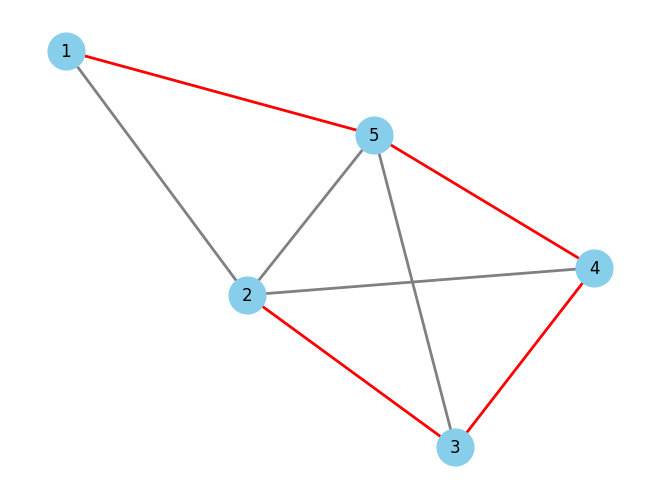

In [172]:
# Prepare edge colors
edge_colors = []
for u, v in G_nx.edges():
    if (u, v) in path or (v, u) in path:
        edge_colors.append('red')  # Hamiltonian path edges in red
    else:
        edge_colors.append('gray')  # Other edges in gray

# Draw
pos = nx.spring_layout(G_nx)  # layout
nx.draw(G_nx, pos, with_labels=True, edge_color=edge_colors, node_color='skyblue', node_size=700, width=2)
plt.show()


In [173]:
class LCT:
  def __init__(self, n):
    # Initialize the Link-Cut Tree with n nodes
    self.n = n
    self.ch = [[0, 0] for i in range(n + 1)]  # Children array
    self.fa = [0 for i in range(n + 1)]  # Parent array
    self.rev = [0 for i in range(n + 1)]  # Reverse flag array

  def isr(self, a):
    # Check if node a is a root of its splay tree
    return not (self.ch[self.fa[a]][0] == a or self.ch[self.fa[a]][1] == a)

  def pushdown(self, a):
    # Propagate the reverse operation down the tree
    if self.rev[a]:
      self.rev[self.ch[a][0]] ^= 1
      self.rev[self.ch[a][1]] ^= 1
      self.ch[a][0], self.ch[a][1] = self.ch[a][1], self.ch[a][0]  # Swap children
      self.rev[a] = 0

  def push(self, a):
    # Push changes down to ensure the node a is up-to-date
    if not self.isr(a):
      self.push(self.fa[a])
    self.pushdown(a)

  def rotate(self, a):
    # Perform a rotation on node a
    f = self.fa[a]
    gf = self.fa[f]
    tp = self.ch[f][1] == a
    son = self.ch[a][tp ^ 1]
    if not self.isr(f):
      self.ch[gf][self.ch[gf][1] == f] = a
    self.fa[a] = gf
    self.ch[f][tp] = son
    if son:
      self.fa[son] = f
    self.ch[a][tp ^ 1] = f
    self.fa[f] = a

  def splay(self, a):
    self.push(a)
    while not self.isr(a):
        f = self.fa[a]
        gf = self.fa[f]
        if self.isr(f):
            self.rotate(a)
        else:
            tp1 = (self.ch[gf][1] == f)
            tp2 = (self.ch[f][1] == a)
            if tp1 == tp2:
                self.rotate(f)
                self.rotate(a)
            else:
                self.rotate(a)
                self.rotate(a)


  def access(self, a):
    # Make node a the root of the preferred path
    pr = a
    self.splay(a)
    self.ch[a][1] = 0
    while True:
      if self.fa[a]==0:
        break
      f = self.fa[a]
      self.splay(f)
      self.ch[f][1]=a
      a=f
    self.splay(pr)

  def makeroot(self, a):
    # Make node a the root of the entire tree
    self.access(a)
    self.rev[a] ^= 1

  def link(self, a, b):
    # Link node a to node b
    self.makeroot(a)
    self.fa[a] = b

  def cut(self, a, b):
    # Cut the connection between node a and node b
    self.makeroot(a)
    self.access(b)
    self.fa[a] = 0
    self.ch[b][0]=0

  def fdr(self, a):
    # Find the root of the tree containing node a
    self.access(a)
    while True:
      self.pushdown(a)
      if self.ch[a][0]:
        a = self.ch[a][0]
      else:
        self.splay(a)
        return a
  

In [174]:
def hamiltonian(n,edges,mx_ch=-1):
    #mx_ch : max number of adding/replacing  default is (n + 100) * (n + 50) 
    # n : number of vertices. 1-indexed. 
    # eg: vector<pair<int, int> > storing all the edges. 
    # return a vector<int> consists of all indices of vertices on the path. return empty list if failed to find one. 
    out=[0 for _ in range(n+1)]
    ine=[0 for _ in range(n+1)]
    lc=LCT(n)
    if mx_ch == -1: 
        mx_ch = (n + 100) * (n + 50)
    frm=[[] for  _ in range(n+1)]
    to=[[] for  _ in range(n+1)]
    for u,v in edges:
        frm[u].append(v)
        to[v].append(u)
    canin = set()
    canout=set()
    for i in range(1,n+1):
        canin.add(i)
        canout.add(i)
    tot=0
    while mx_ch>=0:
        eg=[]
        for v in canout:
            for s in frm[v]:
                if ine[s]==0:
                    assert(s in canin)
                    continue
                else:
                    eg.append((v,s))
        for v in canin:
            for s in to[v]:
                eg.append((s,v))
        random.shuffle(eg)
        if len(eg)==0:
            break
        for u,v in eg:
            mx_ch-=1
            if ine[v] and out[u]:
                continue
            if lc.fdr(u)==lc.fdr(v):
                continue
            if ine[v] or out[u]:
                if random.choice([0,1]):
                    continue
            if ine[v]==0 and  out[u]==0 :
                tot+=1
            if ine[v]:
                lc.cut(ine[v],v)
                canin.add(v)
                canout.add(ine[v])
                out[ine[v]] = 0
                ine[v] = 0
            if out[u]:
                lc.cut(u,out[u])
                canin.add(out[u])
                canout.add(u)
                ine[out[u]]=0
                out[u]=0
            lc.link(u,v)
            canin.remove(v)
            canout.remove(u)
            ine[v]=u
            out[u]=v
    if tot==n-1:
        cur=[]
        for i in range(1,n+1):
            if ine[i]==0:
                pl=i
                while(pl>0):
                    cur.append(pl)
                    pl=out[pl]
                break
        return cur
    return  []


In [177]:

# Paste your corrected LCT and hamiltonian code here

# Test Case 1: Straight path
print("=== Test 1: Straight Path ===")
edges = [(2,3),(3,4),(4,5),(5,6),(6,8),(8,7),(1,8),(1,2),(2,5),(3,6),(3,7)]
n = 8
print(hamiltonian(n, edges))



=== Test 1: Straight Path ===
[1, 2, 3, 4, 5, 6, 8, 7]
